In [2]:
%pip install tensorflow opencv-python mediapipe scikit-learn matplotlib pandas pyarrow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 36.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 46.8 MB/s eta 0:00:00:00:01
  Attempting uninstall: keras
    Found existing installation: keras 3.0.5
    Uninstalling keras-3.0.5:
      Successfully uninstalled keras-3.0.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
Note: you may need to restart the kernel to use updated packages.


In [135]:
import os
import math
import pandas as pd
import numpy as np
#Load parquet data into dataset_parquet for training.
import tensorflow as tf
from tensorflow import keras
from glob import glob
from tqdm import tqdm
import random
import time

In [167]:
class CONFIG:
    root = os.path.join("/", "kaggle", "input", "asl-signs") 
    DATA_LIMIT = 1000
    BATCH_SIZE = 8
    VIDEO_LENGTH = 60
    TRAIN_VAL_SPLIT = 0.8

In [5]:
os.listdir(CONFIG.root)

['sign_to_prediction_index_map.json', 'train.csv', 'train_landmark_files']

In [7]:
#simple code to read parquet files
# Path to your Parquet file
parquet_file_path = os.path.join(os.path.join(CONFIG.root,'train_landmark_files/2044/3127189.parquet'))

# Read the Parquet file
df = pd.read_parquet(parquet_file_path)

# Display the first few rows of the dataframe to view the landmarks
print(df.head())

   frame     row_id  type  landmark_index         x         y         z
0     21  21-face-0  face               0  0.479847  0.478954 -0.044969
1     21  21-face-1  face               1  0.469082  0.439374 -0.069958
2     21  21-face-2  face               2  0.472504  0.453134 -0.040229
3     21  21-face-3  face               3  0.458673  0.407925 -0.045351
4     21  21-face-4  face               4  0.468096  0.428457 -0.072840


In [8]:
#this code sorts out a parquet files and rearrange the order to pose,face, left-hand, right-hand
import os
import pandas as pd
import numpy as np

ids = None

order_global = {"pose" : 10000, "face" : 1000, "left_hand" : 100, "right_hand" : 10}

def process_parquet(ds):
    ret = []
    frames_unique = sorted(np.unique(ds["frame"]))
    for i,frame in enumerate(frames_unique):
        frame_ds = ds[ds['frame'] == frame]
        
        order = []
        for el in frame_ds["row_id"]:
            _frame, part, keypoint = el.split("-")
            order.append(order_global[part] - int(keypoint))

        order = np.array(order)
        frame_ds.iloc[:, 1] = order
        frame_ds = frame_ds.sort_values(by="row_id", ascending=False)
    
        vals = np.array(frame_ds[["x", "y", "z"]]).flatten()

        ret.append(vals)
    return np.array(ret)
        
#process_parquet("79631423.parquet")

In [168]:
from sklearn.model_selection import train_test_split

#custom class to load data from Parquet files for training ML models.
class ParquetDataset(keras.utils.Sequence):
    def __init__(self, dataset_folder, csv_file : str, batch_size=CONFIG.BATCH_SIZE, 
                 data_limit :int= CONFIG.DATA_LIMIT, check_if_file_exists = True, 
                 preprocessing_func=None, frame_length :int = CONFIG.VIDEO_LENGTH,
                 split : str = "train", train_val_split : float = CONFIG.TRAIN_VAL_SPLIT,
                 sort_by_counts : bool = True
                ):
        #taking keras sequence for .fit(), .evaluate(), .predict() methods
        #load csv - it has the path to parquet file, and another to store label
        self.csv_path = csv_file
        self.root_folder = dataset_folder
        self.batch_size = batch_size
        #optional pre-processing function to the parquet files.
        self.preprocessing_func = preprocessing_func
        
        self.csv_data = pd.read_csv(self.csv_path)
        
        self.all_files = []
        self.not_exists = []
        self.frame_length = frame_length

        
        for path, label in tqdm(list(zip(self.csv_data["path"], self.csv_data["sign"]))):
            prop_path = os.path.join(self.root_folder, path)
            
            if check_if_file_exists:
                if os.path.exists(prop_path):
                    self.all_files.append((prop_path, label))
                else:
                    self.not_exists.append(prop_path)
            else:
                self.all_files.append((prop_path, label))
                
                    
        self.all_files = np.array(self.all_files)
        self.unique_labels = np.unique(self.all_files[:, 1])
        self.label_2_id = { key : i for i, key in enumerate(self.unique_labels)}
    
        # sort the values by popularity
        if sort_by_counts:
            cnt = Counter(self.all_files[:, 1])
            vals = []
            
            for i,row in enumerate(self.all_files):
                vals.append((int(1e6 * cnt[row[1]] + self.label_2_id [row[1]]),i))
            
            vals = np.array(sorted(vals)[::-1])
            self.all_files = self.all_files[vals[:,1]]

        
        if data_limit < 0:
            train_ds, val_ds = train_test_split(self.all_files, train_size=train_val_split, random_state=42)
        else:
            train_ds, val_ds = train_test_split(self.all_files[:data_limit], train_size=train_val_split, random_state=42)
            self.unique_labels = np.unique(self.all_files[:data_limit, 1])
            self.label_2_id = { key : i for i, key in enumerate(self.unique_labels)}
            
        if split.lower() == "train":
            self.dataset = train_ds
            
        elif split.lower() == "val":
            self.dataset = val_ds 
            
        else:
            raise Exception("please specify split to be either train or val")
            
        np.random.shuffle(self.dataset)
                   

    def __len__(self):
        # Assuming each Parquet file should be one batch; adjust if necessary
        return math.ceil(len(self.dataset) / self.batch_size)
    
    def get_single(self, idx):
        # Load one file per batch
        #take the idx value, 1st label, 
        path, label = self.dataset[idx]
        
        df = pd.read_parquet( path)
        
        # Apply preprocessing if specified
        if self.preprocessing_func:
            df = self.preprocessing_func(df, self.frame_length)
        
        one_hot_encoded_label = np.zeros(len(self.unique_labels))
        one_hot_encoded_label[self.label_2_id[label]] = 1  
        
        return df, one_hot_encoded_label

    def __getitem__(self, idx):
        X, Y = [], []
        
        low = idx * self.batch_size
        high = min(low + self.batch_size, len(self.dataset))
        
        for i in range(low, high):
            x, y = self.get_single(i)
            X.append(x)
            Y.append(y)
        
        return np.array(X), np.array(Y)
                
        
    def on_epoch_end(self):
        # Shuffle files for the next epoch
        np.random.shuffle(self.dataset)

def my_preprocessing_func(df, frame_length):
    
    # Define your preprocessing steps here
    # Example: normalize numerical features
    frames_mediapipe = process_parquet(df)
    
    current_length, num_features = frames_mediapipe.shape

    if current_length >= frame_length:
            # TODO: a better than uniform value ? Could place gaussian in the middle
            random_start = random.randint(0, current_length - frame_length)
            return np.nan_to_num(frames_mediapipe[random_start : (random_start + frame_length)])
        
    # padd the video to contain zeros 
    return np.concatenate([np.nan_to_num(frames_mediapipe), np.zeros((frame_length - current_length, num_features))], axis=0)
    
# Usage example
parquet_folder_path = CONFIG.root
train_dataset_parquet = ParquetDataset(parquet_folder_path, csv_file = os.path.join(CONFIG.root, "train.csv"), 
                                 batch_size=CONFIG.BATCH_SIZE, data_limit=CONFIG.DATA_LIMIT,
                                 preprocessing_func=my_preprocessing_func,
                                check_if_file_exists = False,
                                split="train")

val_dataset_parquet = ParquetDataset(parquet_folder_path, csv_file = os.path.join(CONFIG.root, "train.csv"), 
                                 batch_size=CONFIG.BATCH_SIZE, data_limit=CONFIG.DATA_LIMIT,
                                 preprocessing_func=my_preprocessing_func,
                                 check_if_file_exists= False,
                                 split="val")

print(f"cardinality of train : {len(train_dataset_parquet)}, cardinality of validation : {len(val_dataset_parquet)}")

100%|██████████| 94477/94477 [00:00<00:00, 307440.00it/s]


cardinality of train : 100, cardinality of validation : 25


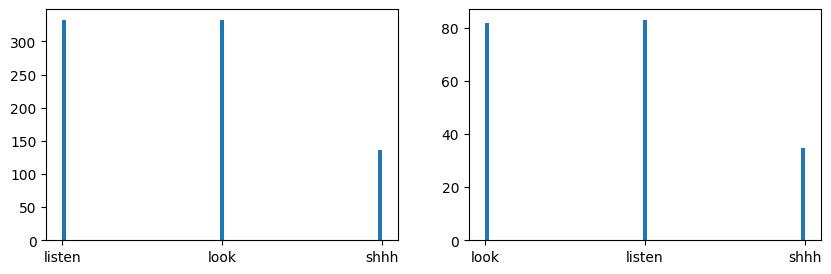

In [169]:
import matplotlib.pyplot as plt 


plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.hist(train_dataset_parquet.dataset[:, 1], bins=len(dataset_parquet.unique_labels))

plt.subplot(1, 2, 2)
plt.hist(val_dataset_parquet.dataset[:, 1], bins=len(dataset_parquet.unique_labels))

plt.show()

In [170]:
start = time.time()
isnans =False

f = True
labels_batches = []
for el in tqdm(train_dataset_parquet):
    if f:
        print(el[0].shape, el[1].shape)
        f = False
    labels_batches.append(el[1])
        
    isnans |= np.any(np.isnan(el[0]))
    if isnans:
        print("FOUND NAN!")
        break


print(f"Iterating through dataset took : {round( time.time() - start , 4)}s")

  1%|          | 1/100 [00:00<01:05,  1.52it/s]

(8, 60, 1629) (8, 3)


  6%|▌         | 6/100 [00:05<01:27,  1.07it/s]


KeyboardInterrupt: 

# Train simple LSTM

In [174]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import backend as K
import tensorflow as tf

model = Sequential()
#x,y,z -> y,z as the input shape
model.add(LSTM(128, return_sequences=False, activation='relu', input_shape=(CONFIG.VIDEO_LENGTH, 1629)))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))

#Adam Optimizer - fixed learning rate.
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)


model.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print(model.summary())

model.fit(train_dataset_parquet, epochs=100, validation_data = val_dataset_parquet, batch_size = 8, callbacks=[])

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_25 (LSTM)              (None, 128)               900096    
                                                                 
 dense_32 (Dense)            (None, 128)               16512     
                                                                 
 dense_33 (Dense)            (None, 256)               33024     
                                                                 
 dense_34 (Dense)            (None, 3)                 771       
                                                                 
Total params: 950403 (3.63 MB)
Trainable params: 950403 (3.63 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/100
100/100 [==============================] - 113s 1s/step - loss: 1.0960 - categorical_accuracy: 0.4112 - val_loss: 1.0782 - val_categ

In [176]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import backend as K
import tensorflow as tf

model = Sequential()
#x,y,z -> y,z as the input shape
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(CONFIG.VIDEO_LENGTH, 1629)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


#Adam Optimizer - fixed learning rate.
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)


model.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print(model.summary())

model.fit(train_dataset_parquet, epochs=100, validation_data = val_dataset_parquet, batch_size = 8, callbacks=[])

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_29 (LSTM)              (None, 60, 64)            433664    
                                                                 
 lstm_30 (LSTM)              (None, 60, 128)           98816     
                                                                 
 lstm_31 (LSTM)              (None, 64)                49408     
                                                                 
 dense_38 (Dense)            (None, 128)               8320      
                                                                 
 dense_39 (Dense)            (None, 256)               33024     
                                                                 
 dense_40 (Dense)            (None, 3)                 771       
                                                                 
Total params: 624003 (2.38 MB)
Trainable params: 6240

KeyboardInterrupt: 

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import backend as K
import tensorflow as tf

model = Sequential()
#x,y,z -> y,z as the input shape
model.add(LSTM(64, return_sequences=False, activation='relu', input_shape=(CONFIG.VIDEO_LENGTH, 1629)))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))

#Adam Optimizer - fixed learning rate.
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)


model.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print(model.summary())

model.fit(train_dataset_parquet, epochs=100, validation_data = val_dataset_parquet, batch_size = 16, callbacks=[])

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_32 (LSTM)              (None, 64)                433664    
                                                                 
 dense_41 (Dense)            (None, 128)               8320      
                                                                 
 dense_42 (Dense)            (None, 256)               33024     
                                                                 
 dense_43 (Dense)            (None, 3)                 771       
                                                                 
Total params: 475779 (1.81 MB)
Trainable params: 475779 (1.81 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/100
100/100 [==============================] - 113s 1s/step - loss: 1.0939 - categorical_accuracy: 0.4225 - val_loss: 1.0831 - val_categ